In [ ]:
%pip install tensorflow pandas scikit-learn requests beautifulsoup4 tensorflow.keras

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier  # Added XGBoost
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from joblib import dump
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [ ]:
legit_data = pd.read_csv("final_legitimate.csv")
phish_data = pd.read_csv("final_phishing.csv")

In [ ]:
combined_data = pd.concat([legit_data, phish_data], axis=0)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
before_dedup = combined_data.shape[0]
combined_data = combined_data.drop_duplicates()
after_dedup = combined_data.shape[0]

X = combined_data.drop(columns=['label'])
y = combined_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
nn = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42) 
xgb = XGBClassifier(random_state=42)

In [ ]:
K = 5
kf =KFold(n_splits=K, shuffle=True, random_state=42) 
# skf=StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [ ]:
metrics = {
    'RF': {'accuracy': [], 'precision': [], 'recall': [], 'roc_auc': []},
    'NN': {'accuracy': [], 'precision': [], 'recall': [], 'roc_auc': []},  # Changed from AB to NN
    'XGB': {'accuracy': [], 'precision': [], 'recall': [], 'roc_auc': []},
    'VotingSoft': {'accuracy': [], 'precision': [], 'recall': [], 'roc_auc': []}
}

In [ ]:
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    for model_name, model in zip(['RF', 'NN', 'XGB'], [rf, nn, xgb]):  
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)
        y_pred_proba = model.predict_proba(X_test_fold)[:, 1]

        acc = accuracy_score(y_test_fold, y_pred)
        prec = precision_score(y_test_fold, y_pred)
        rec = recall_score(y_test_fold, y_pred)
        roc = roc_auc_score(y_test_fold, y_pred_proba)

        print(f"{model_name}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, ROC-AUC={roc:.4f}")

        metrics[model_name]['accuracy'].append(acc)
        metrics[model_name]['precision'].append(prec)
        metrics[model_name]['recall'].append(rec)
        metrics[model_name]['roc_auc'].append(roc)

    voting_clf_soft = VotingClassifier(
        estimators=[('rf', rf), ('nn', nn), ('xgb', xgb)], 
        voting='soft'
    )
    voting_clf_soft.fit(X_train_fold, y_train_fold)
    y_pred_voting = voting_clf_soft.predict(X_test_fold)
    y_pred_voting_proba = voting_clf_soft.predict_proba(X_test_fold)[:, 1]  

    acc_voting = accuracy_score(y_test_fold, y_pred_voting)
    prec_voting = precision_score(y_test_fold, y_pred_voting)
    rec_voting = recall_score(y_test_fold, y_pred_voting)
    roc_voting = roc_auc_score(y_test_fold, y_pred_voting_proba)

    print(f"VotingSoft: Accuracy={acc_voting:.4f}, Precision={prec_voting:.4f}, Recall={rec_voting:.4f}, ROC-AUC={roc_voting:.4f}")

    metrics['VotingSoft']['accuracy'].append(acc_voting)
    metrics['VotingSoft']['precision'].append(prec_voting)
    metrics['VotingSoft']['recall'].append(rec_voting)
    metrics['VotingSoft']['roc_auc'].append(roc_voting)

Legitimate data shape: (9768, 45)
Phishing data shape: (9498, 45)
Combined dataset shape: (19266, 45)
Columns before drop: Index(['has_title', 'has_input', 'has_button', 'has_image', 'has_submit',
       'has_link', 'has_password', 'has_email_input', 'has_hidden_element',
       'has_audio', 'has_video', 'number_of_inputs', 'number_of_buttons',
       'number_of_images', 'number_of_option', 'number_of_list',
       'number_of_th', 'number_of_tr', 'number_of_href', 'number_of_paragraph',
       'number_of_script', 'length_of_title', 'has_h1', 'has_h2', 'has_h3',
       'length_of_text', 'number_of_clickable_button', 'number_of_a',
       'number_of_img', 'number_of_div', 'number_of_figure', 'has_footer',
       'has_form', 'has_text_area', 'has_iframe', 'has_text_input',
       'number_of_meta', 'has_nav', 'has_object', 'has_picture',
       'number_of_sources', 'number_of_span', 'number_of_table', 'URL',
       'label'],
      dtype='object')
Columns after drop: Index(['has_title', 'ha

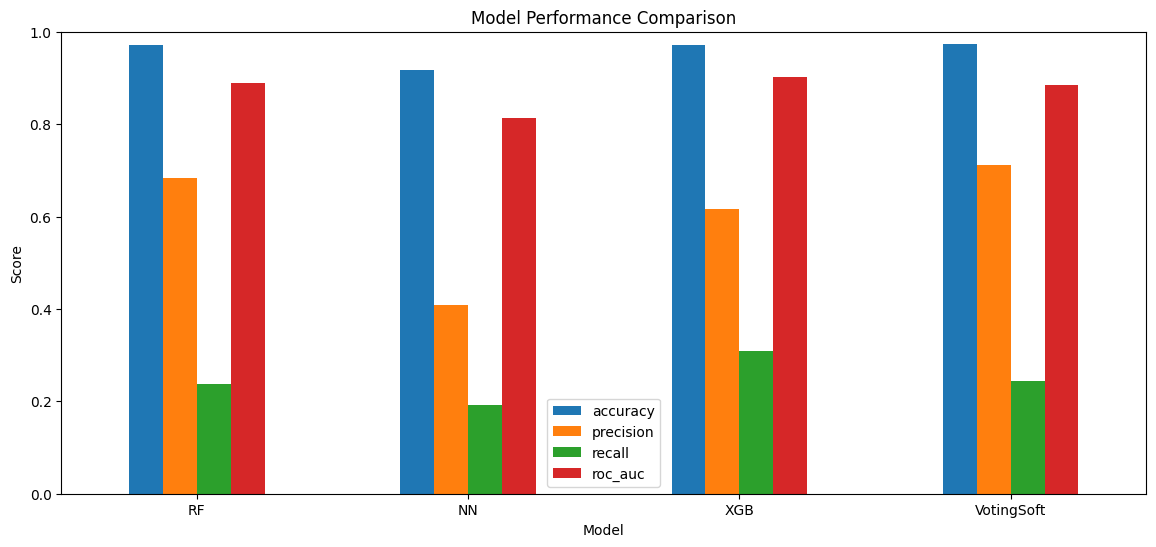

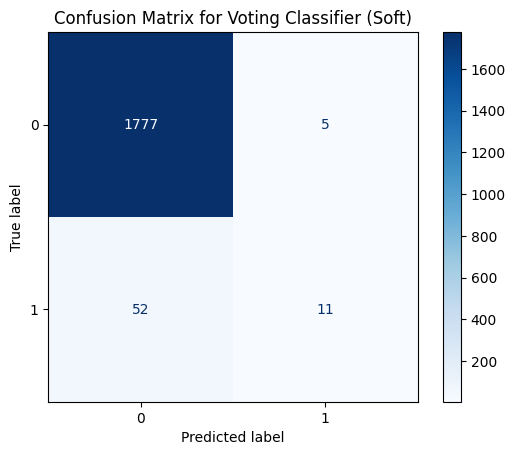

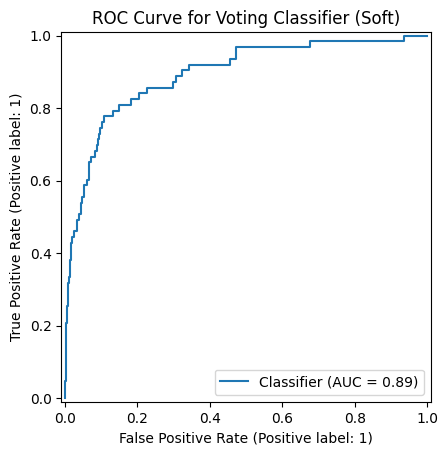

['voting_classifier_soft_model.joblib']

In [ ]:
avg_metrics = {model: {metric: np.mean(values) for metric, values in model_metrics.items()}
               for model, model_metrics in metrics.items()}
for model, model_metrics in avg_metrics.items():
    print(f"{model} - Accuracy: {model_metrics['accuracy']:.4f}, Precision: {model_metrics['precision']:.4f}, Recall: {model_metrics['recall']:.4f}, ROC-AUC: {model_metrics['roc_auc']:.4f}")

df_results = pd.DataFrame(avg_metrics).T
df_results.plot.bar(rot=0, figsize=(14, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.show()

voting_clf_soft.fit(X_train, y_train)
y_pred_voting = voting_clf_soft.predict(X_test)
cm = confusion_matrix(y_test, y_pred_voting)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=voting_clf_soft.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Voting Classifier (Soft)')
plt.show()

y_pred_proba_voting = voting_clf_soft.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_pred_proba_voting)
plt.title('ROC Curve for Voting Classifier (Soft)')
plt.show()


In [ ]:
dump(rf, 'random_forest_model.joblib')
dump(nn, 'neural_network_model.joblib')  
dump(xgb, 'xgboost_model.joblib')
dump(voting_clf_soft, 'voting_classifier_soft_model.joblib')